<a href="https://colab.research.google.com/github/sadneya145/DiagXAI/blob/main/eye_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =====================================
# STEP 1: Install Kaggle CLI
# =====================================
!pip install -q kaggle

import os

# =====================================
# STEP 2: Upload your kaggle.json file
# =====================================
from google.colab import files
print("👉 Please upload your kaggle.json file (downloaded from Kaggle account settings).")
files.upload()  # <-- choose the kaggle.json you just created

# Move it to the correct directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# =====================================
# STEP 3: Download the FULL ODIR-5K dataset (only if not already downloaded)
# =====================================
dataset_dir = "./ODIR5K_full"
dataset_zip = os.path.join(dataset_dir, "ocular-disease-recognition-odir5k.zip")

if not os.path.exists(dataset_dir):
    print("⬇️ Downloading ODIR-5K dataset (first time only)...")
    !mkdir -p "$dataset_dir"
    !kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k -p "$dataset_dir"
    !unzip -q "$dataset_zip" -d "$dataset_dir"
    print("✅ Download complete and extracted!")
else:
    print("✅ Dataset already exists, skipping download!")

# =====================================
# STEP 4: Verify folder structure
# =====================================
import os
for root, dirs, files in os.walk(dataset_dir):
    level = root.replace(dataset_dir, "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    for f in files[:5]:
        print(f"{indent}  {f}")



👉 Please upload your kaggle.json file (downloaded from Kaggle account settings).


Saving kaggle.json to kaggle.json
⬇️ Downloading ODIR-5K dataset (first time only)...
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k
License(s): other
100% 1.62G/1.62G [00:12<00:00, 200MB/s]
100% 1.62G/1.62G [00:12<00:00, 140MB/s]
✅ Download complete and extracted!
ODIR5K_full/
  full_df.csv
  ocular-disease-recognition-odir5k.zip
  preprocessed_images/
    2952_right.jpg
    2844_left.jpg
    2591_right.jpg
    3226_right.jpg
    2832_right.jpg
  ODIR-5K/
    ODIR-5K/
      data.xlsx
      Training Images/
        2952_right.jpg
        2844_left.jpg
        2591_right.jpg
        3226_right.jpg
        459_right.jpg
      Testing Images/
        4668_left.jpg
        1193_right.jpg
        2040_left.jpg
        3454_right.jpg
        4774_left.jpg


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

import os
import itertools
import cv2
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers


import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_csv = os.path.join("./ODIR5K_full", "full_df.csv")
data = pd.read_csv(data_csv)

print("Dataset preview:")
print(data.head())

Dataset preview:
   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   4           53        Male  4_left.jpg  4_right.jpg   
4   5           50      Female  5_left.jpg  5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  \
0                           normal fundus  0  0  0  1  0  0  0  0   
1                           normal fundus  1  0  0  0  0  0  0  0   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1   
3       mild no

In [ ]:
data.columns

Index(['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
       'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
       'C', 'A', 'H', 'M', 'O', 'filepath', 'labels', 'target', 'filename'],
      dtype='object')

In [ ]:
len(data)

6392

In [ ]:
data.isnull().sum()

,0
ID,0
Patient Age,0
Patient Sex,0
Left-Fundus,0
Right-Fundus,0
Left-Diagnostic Keywords,0
Right-Diagnostic Keywords,0
N,0
D,0
G,0


In [ ]:
print("Dataset Shape:", data.shape)
print("\nSample rows:")
display(data.head())

print("\nData Info:")
print(data.info())

print("\nClass Distribution (sum of each disease):")
print(data[data == 1].sum(axis=0))

Dataset Shape: (6392, 19)

Sample rows:


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 

##### Normal (N),
##### Diabetes (D),
##### Glaucoma (G),
##### Cataract (C),
##### Age related Macular Degeneration (A),
##### Hypertension (H),
##### Pathological Myopia (M),
##### Other diseases/abnormalities (O)

In [ ]:
photo_counts = data['Left-Fundus'].value_counts()

# Filter names that appear more than once
photo_more_than_once = photo_counts[photo_counts > 1].index.tolist()

print(len(photo_more_than_once))

photo_more_than_once[0]

3034


'4690_left.jpg'

In [ ]:
data[data['Left-Fundus'] == '4784_left.jpg']

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
3193,4784,58,Male,4784_left.jpg,4784_right.jpg,hypertensive retinopathy，age-related macular d...,hypertensive retinopathy，age-related macular d...,0,0,0,0,1,1,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['H'],"[0, 0, 0, 0, 0, 1, 0, 0]",4784_right.jpg
6391,4784,58,Male,4784_left.jpg,4784_right.jpg,hypertensive retinopathy，age-related macular d...,hypertensive retinopathy，age-related macular d...,0,0,0,0,1,1,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['H'],"[0, 0, 0, 0, 0, 1, 0, 0]",4784_left.jpg


**Analysis**
Finding out inconsistencies

In [ ]:
print(len(data[(data['labels'] == "['N']") & (data['N'] != 1)]))
print(len(data[(data['labels'] == "['D']") & (data['D'] != 1)]))
print(len(data[(data['labels'] == "['O']") & (data['O'] != 1)]))
print(len(data[(data['labels'] == "['C']") & (data['C'] != 1)]))
print(len(data[(data['labels'] == "['G']") & (data['G'] != 1)]))
print(len(data[(data['labels'] == "['A']") & (data['A'] != 1)]))
print(len(data[(data['labels'] == "['M']") & (data['M'] != 1)]))
print(len(data[(data['labels'] == "['H']") & (data['H'] != 1)]))

772
0
3
0
0
0
0
0


In [ ]:
data.drop(columns=[ 'ID'] , inplace=True)

In [ ]:
len(data[data['Patient Age'] == 1])

28

In [ ]:
def update_labels(row):

    new_label = ''
    for col in data.columns:
        if row[col] == 1 and col != 'Patient Age':
            new_label = new_label + col
    row['labels'] = new_label
    return row

data = data.apply(update_labels, axis=1)

In [ ]:
data['labels'].nunique()

37

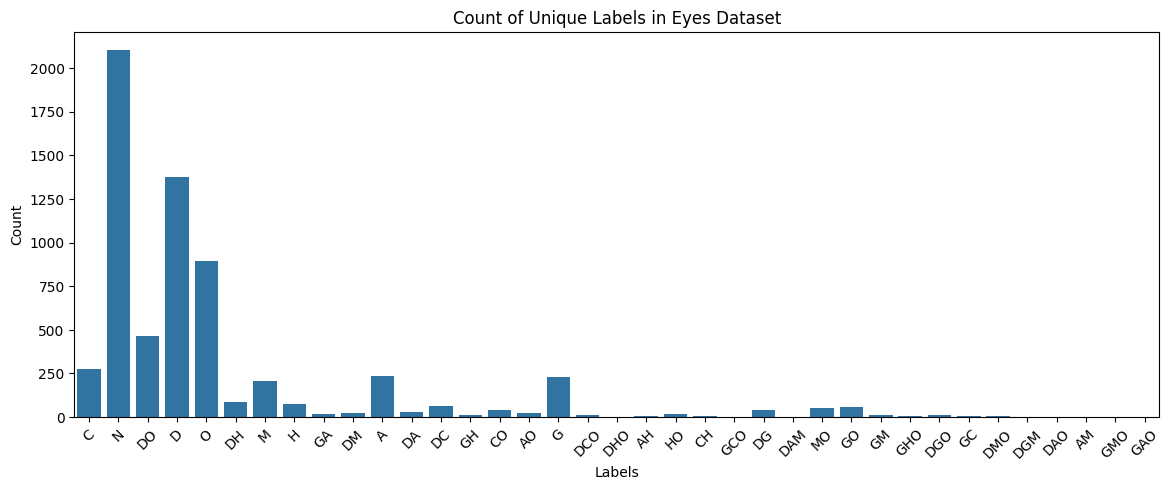

In [ ]:
plt.figure(figsize=(14, 5))
sns.countplot(x='labels', data=data, orient='h')
plt.title('Count of Unique Labels in Eyes Dataset')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
data[data['Left-Diagnostic Keywords'] == 'low image quality']

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
2547,45,Male,3935_left.jpg,3935_right.jpg,low image quality,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",3935_right.jpg
2606,71,Male,4007_left.jpg,4007_right.jpg,low image quality,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4007_right.jpg
2744,48,Male,4169_left.jpg,4169_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4169_right.jpg
2854,51,Male,4290_left.jpg,4290_right.jpg,low image quality,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",4290_right.jpg
2989,62,Female,4442_left.jpg,4442_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4442_right.jpg
2994,50,Male,4448_left.jpg,4448_right.jpg,low image quality,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4448_right.jpg
3053,67,Male,4522_left.jpg,4522_right.jpg,low image quality,severe nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4522_right.jpg


In [ ]:
data[data['Right-Diagnostic Keywords'] == 'low image quality']

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
3517,52,Female,372_left.jpg,372_right.jpg,"low image quality,maculopathy",low image quality,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,O,"[0, 0, 0, 0, 0, 0, 0, 1]",372_left.jpg
5748,62,Male,3947_left.jpg,3947_right.jpg,moderate non proliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",3947_left.jpg
5848,80,Female,4066_left.jpg,4066_right.jpg,moderate non proliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4066_left.jpg
5901,43,Male,4124_left.jpg,4124_right.jpg,moderate non proliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4124_left.jpg
5947,63,Male,4180_left.jpg,4180_right.jpg,moderate non proliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4180_left.jpg
5963,58,Female,4198_left.jpg,4198_right.jpg,moderate non proliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4198_left.jpg
6025,60,Male,4262_left.jpg,4262_right.jpg,mild nonproliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4262_left.jpg
6080,69,Male,4319_left.jpg,4319_right.jpg,moderate non proliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4319_left.jpg
6146,56,Male,4394_left.jpg,4394_right.jpg,mild nonproliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4394_left.jpg
6176,43,Male,4427_left.jpg,4427_right.jpg,mild nonproliferative retinopathy,low image quality,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",4427_left.jpg


In [ ]:
data = data.loc[(data['Left-Diagnostic Keywords'] != 'low image quality')]
data = data.loc[(data['Right-Diagnostic Keywords'] != 'low image quality')]
print(len(data[(data['labels'] == "['N']") & (data['N'] != 1)]))
print(len(data[(data['labels'] == "['O']") & (data['O'] != 1)]))
data.head()

0
0


,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,C,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,DO,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,DO,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,D,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [ ]:
photos_unique = data.drop_duplicates(subset='Left-Fundus', keep='first')
data = photos_unique
data.reset_index(drop=True,inplace=True)
len(data)

3340

In [ ]:
data['Left-Diagnostic Keywords'].nunique()

194

In [ ]:
data['Right-Diagnostic Keywords'].nunique()

204

In [ ]:
data['Left-Diagnostic Keywords'].mode()

,Left-Diagnostic Keywords
0,normal fundus


In [ ]:
data['Left-Diagnostic Keywords'].value_counts()

,count
Left-Diagnostic Keywords,
normal fundus,1433
moderate non proliferative retinopathy,359
mild nonproliferative retinopathy,217
cataract,135
pathological myopia,111
...,...
epiretinal membrane，epiretinal membrane，lens dust,1
moderate non proliferative retinopathy，myelinated nerve fibers，laser spot,1
glaucoma，mild nonproliferative retinopathy，macular pigmentation disorder,1


In [ ]:
# Checking normal fundus count as it appears most of the times
len(data[data['Left-Diagnostic Keywords'] == 'normal fundus'])

1433

In [ ]:
# Checking which values appear the most
data['Right-Diagnostic Keywords'].mode()

,Right-Diagnostic Keywords
0,normal fundus


In [ ]:
# Checking the count of the normal fundus for right eye
len(data[data['Right-Diagnostic Keywords'] == 'normal fundus'])

1382

In [ ]:
# Creating new df for the patients with both eyes normal

both_eyes_normal = data[
    (data['Right-Diagnostic Keywords'] == 'normal fundus') &
    (data['Left-Diagnostic Keywords'] == 'normal fundus')
]

both_eyes_normal.reset_index(inplace=True,drop=True)

len(both_eyes_normal)

1001

In [ ]:
# Creating new df for the patients with both eyes NOT normal

both_eyes_not_normal = data[
    (data['Right-Diagnostic Keywords'] != 'normal fundus') &
    (data['Left-Diagnostic Keywords'] != 'normal fundus')
]

both_eyes_not_normal.reset_index(inplace=True,drop=True)

len(both_eyes_not_normal)

1526

In [ ]:
# Checking count for normal right eye

left_eye_abnormalities = data[
    (data['Right-Diagnostic Keywords'] == 'normal fundus') &
    (data['Left-Diagnostic Keywords'] != 'normal fundus')
]

left_eye_abnormalities.reset_index(inplace=True,drop=True)

In [ ]:
len(left_eye_abnormalities)

381

In [ ]:
left_eye_abnormalities[(left_eye_abnormalities['labels'] == 'N')].head(5)

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
269,68,Male,2400_left.jpg,2400_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2400_right.jpg
270,33,Male,2483_left.jpg,2483_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2483_right.jpg
271,50,Female,2486_left.jpg,2486_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2486_right.jpg
272,68,Female,2495_left.jpg,2495_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2495_right.jpg
273,52,Female,2496_left.jpg,2496_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2496_right.jpg


In [ ]:
# Checking count for right eye abnormalities

right_eye_abnormalities = data[
    (data['Right-Diagnostic Keywords'] != 'normal fundus') &
    (data['Left-Diagnostic Keywords'] == 'normal fundus')
]
right_eye_abnormalities.reset_index(inplace=True,drop=True)

len(right_eye_abnormalities)

432

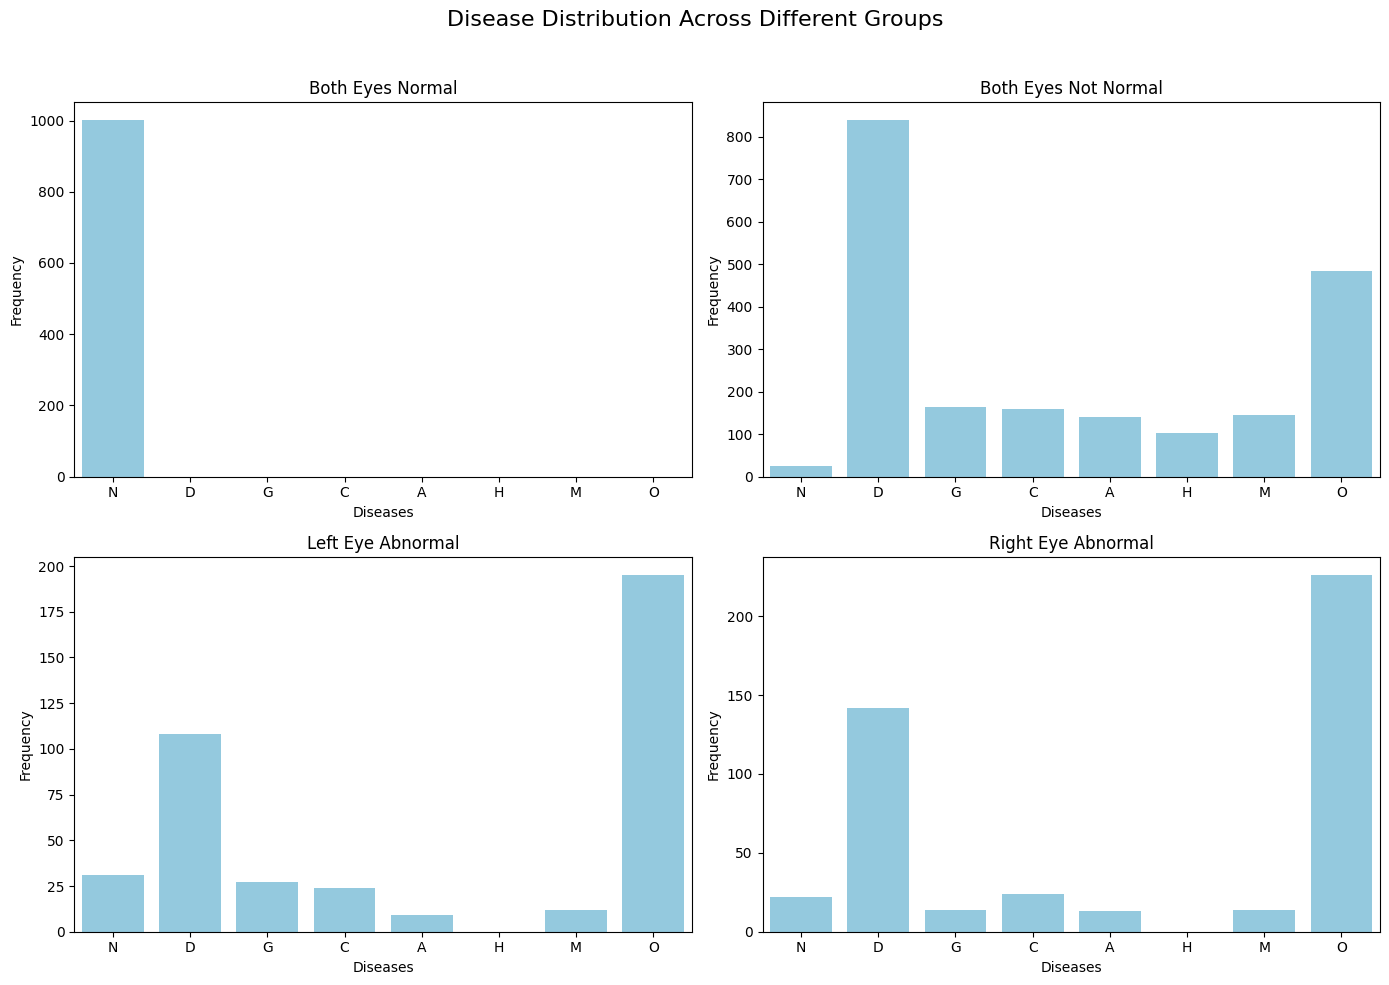

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Disease Distribution Across Different Groups', fontsize=16)

# Define titles for the subplots
titles = [
    'Both Eyes Normal',
    'Both Eyes Not Normal',
    'Left Eye Abnormal',
    'Right Eye Abnormal'
]

# Create a list of DataFrames
dataframes = [both_eyes_normal, both_eyes_not_normal, left_eye_abnormalities, right_eye_abnormalities]

# Loop through DataFrames and plot on subplots
for data, ax, title in zip(dataframes, axes.ravel(), titles):
    disease_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    disease_counts = data[disease_columns].sum()

    sns.barplot(x=disease_counts.index, y=disease_counts.values, color='skyblue', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Diseases')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
len(both_eyes_normal)

1001

In [ ]:
# Added additional normal values which was leaking into not normal df to the normal eyes df

filtered_df = both_eyes_not_normal[both_eyes_not_normal['N'] == 1]

both_eyes_normal = pd.concat(
    [both_eyes_normal[both_eyes_normal['N'].isin(filtered_df['N'])], filtered_df],
    axis=0, ignore_index=True
).drop_duplicates()

In [ ]:
len(both_eyes_normal)

1026

In [ ]:
# Keeping only abnormal eyes
both_eyes_not_normal = both_eyes_not_normal.loc[~(both_eyes_not_normal['N'] == 1)]

In [ ]:
# Remove normal left eye fundus values wrongly flagged as abnormal due to "lens dust"
# and move them to the both eyes' normal DataFrame.

left_eye_abnormalities[left_eye_abnormalities['N'] == 1]

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
269,68,Male,2400_left.jpg,2400_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2400_right.jpg
270,33,Male,2483_left.jpg,2483_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2483_right.jpg
271,50,Female,2486_left.jpg,2486_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2486_right.jpg
272,68,Female,2495_left.jpg,2495_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2495_right.jpg
273,52,Female,2496_left.jpg,2496_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2496_right.jpg
274,72,Female,2509_left.jpg,2509_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2509_right.jpg
275,62,Female,2566_left.jpg,2566_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2566_right.jpg
276,34,Male,2629_left.jpg,2629_right.jpg,lens dust，normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2629_right.jpg
277,49,Female,2652_left.jpg,2652_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2652_right.jpg
278,45,Female,2661_left.jpg,2661_right.jpg,normal fundus，lens dust,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2661_right.jpg


In [ ]:
filtered_df = left_eye_abnormalities[left_eye_abnormalities['N'] == 1]

both_eyes_normal = pd.concat(
    [both_eyes_normal[both_eyes_normal['N'].isin(filtered_df['N'])], filtered_df],
    axis=0, ignore_index=True
).drop_duplicates()

In [ ]:
# Filter out left eye normal fundus values mistakenly flagged as abnormalities.
left_eye_abnormalities = left_eye_abnormalities.loc[~(left_eye_abnormalities['N'] == 1)]

In [ ]:
# Checking vice versa with the right eye abnormilities
right_eye_abnormalities[right_eye_abnormalities['N'] == 1]

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
241,46,Female,2370_left.jpg,2370_right.jpg,normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2370_right.jpg
242,69,Male,2520_left.jpg,2520_right.jpg,normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2520_right.jpg
243,51,Male,2954_left.jpg,2954_right.jpg,normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2954_right.jpg
244,63,Female,3283_left.jpg,3283_right.jpg,normal fundus,normal fundus，lens dust,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",3283_right.jpg
412,51,Male,2377_left.jpg,2377_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2377_left.jpg
413,56,Male,2448_left.jpg,2448_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2448_left.jpg
414,39,Male,2515_left.jpg,2515_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2515_left.jpg
415,75,Male,2724_left.jpg,2724_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2724_left.jpg
416,66,Male,2727_left.jpg,2727_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2727_left.jpg
417,62,Female,2729_left.jpg,2729_right.jpg,normal fundus,lens dust，normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,N,"[1, 0, 0, 0, 0, 0, 0, 0]",2729_left.jpg


In [ ]:
# Appending it to both eye normal df
filtered_df = right_eye_abnormalities[right_eye_abnormalities['N'] == 1]

both_eyes_normal = pd.concat(
    [both_eyes_normal[both_eyes_normal['N'].isin(filtered_df['N'])], filtered_df],
    axis=0, ignore_index=True
).drop_duplicates()

In [ ]:
# Filter out right eye normal fundus values mistakenly flagged as abnormalities.
right_eye_abnormalities = right_eye_abnormalities.loc[~(right_eye_abnormalities['N'] == 1)]
len(both_eyes_normal)

1079

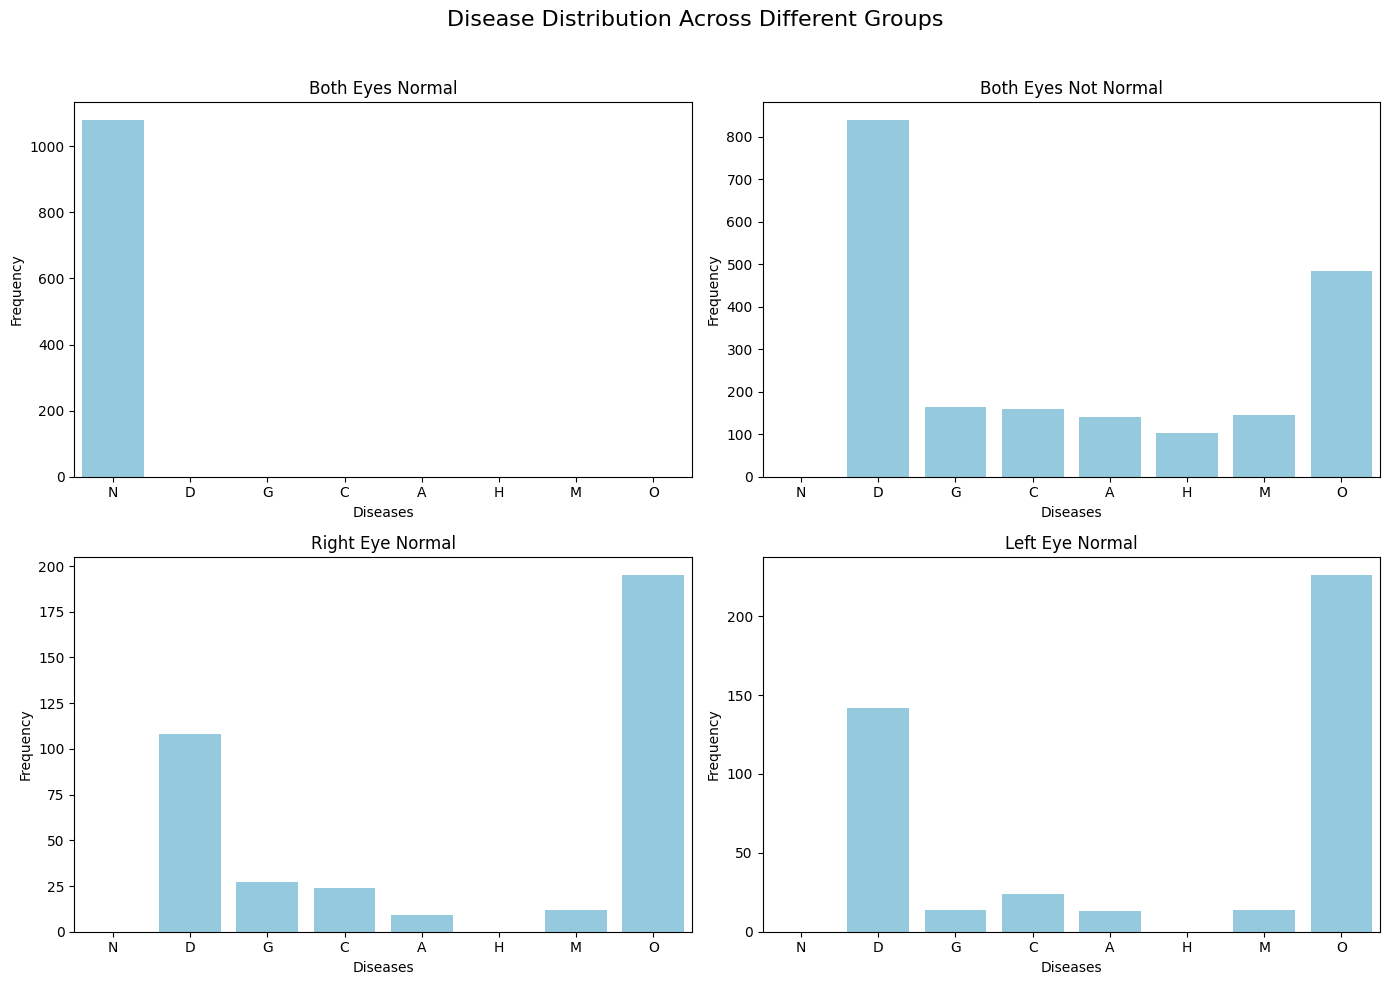

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Disease Distribution Across Different Groups', fontsize=16)

# Define titles for the subplots
titles = [
    'Both Eyes Normal',
    'Both Eyes Not Normal',
    'Right Eye Normal',
    'Left Eye Normal'
]

# Create a list of DataFrames
dataframes = [both_eyes_normal, both_eyes_not_normal, left_eye_abnormalities, right_eye_abnormalities]

# Loop through DataFrames and plot on subplots
for df, ax, title in zip(dataframes, axes.ravel(), titles):
    disease_columns = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    disease_counts = df[disease_columns].sum()

    sns.barplot(x=disease_counts.index, y=disease_counts.values, color='skyblue', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Diseases')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
len(data)

432

In [ ]:
df = pd.concat([left_eye_abnormalities, right_eye_abnormalities, both_eyes_not_normal, both_eyes_normal], ignore_index=True, sort=False)

In [ ]:
len(df)

3340

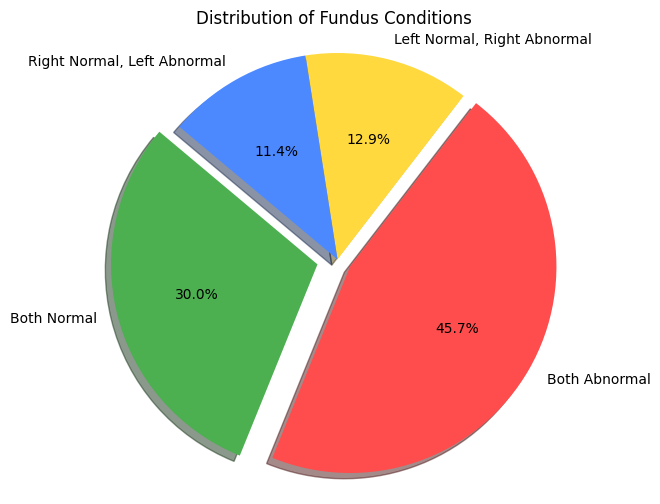

In [ ]:
condition_normal_left = df['Left-Diagnostic Keywords'] == 'normal fundus'
condition_normal_right = df['Right-Diagnostic Keywords'] == 'normal fundus'

# Determine the categories
both_normal = (condition_normal_left) & (condition_normal_right)
both_abnormal = (~condition_normal_left) & (~condition_normal_right)
left_normal_right_abnormal = (condition_normal_left) & (~condition_normal_right)
right_normal_left_abnormal = (~condition_normal_left) & (condition_normal_right)

# Count occurrences for each category
counts = {
    'Both Normal': both_normal.sum(),
    'Both Abnormal': both_abnormal.sum(),
    'Left Normal, Right Abnormal': left_normal_right_abnormal.sum(),
    'Right Normal, Left Abnormal': right_normal_left_abnormal.sum()
}

# Create a pie chart
labels = counts.keys()
sizes = counts.values()
colors = ['#4CAF50','#FF4C4C','#FFD93D','#4C89FF']
explode = (0.1, 0.07, 0, 0)  # explode the 1st slice (optional)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Fundus Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Show the pie chart
plt.show()

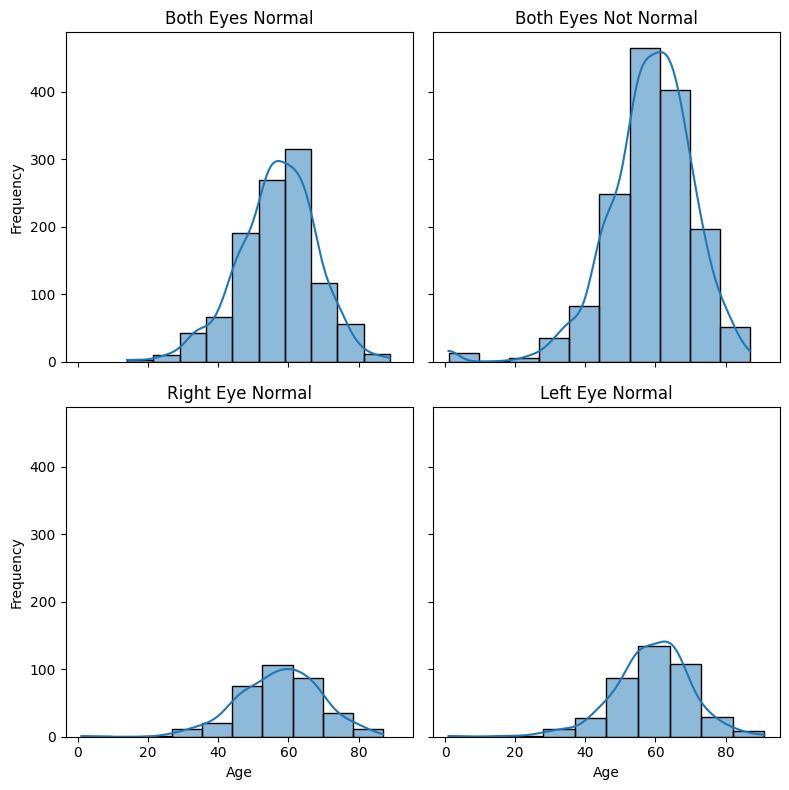

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()  # Converts 2x2 array to 1D array [0,1,2,3]

for i, (eyes, title) in enumerate(zip(dataframes, titles)):
    sns.histplot(eyes['Patient Age'], kde=True, bins=10, ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

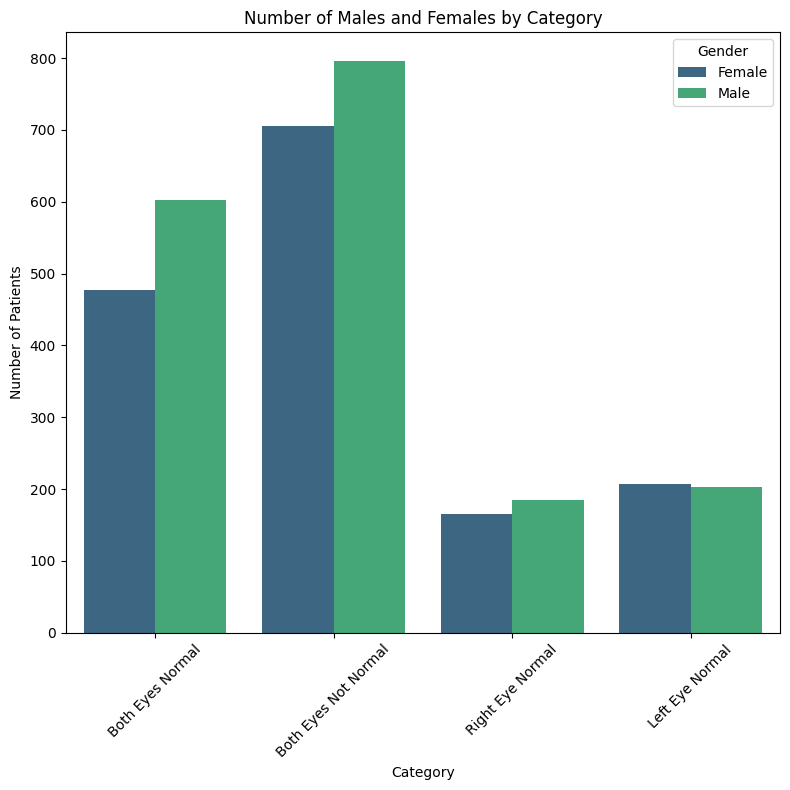

In [ ]:
counts = {
    'Both Eyes Normal': both_eyes_normal['Patient Sex'].value_counts(),
    'Both Eyes Not Normal': both_eyes_not_normal['Patient Sex'].value_counts(),
    'Right Eye Normal': left_eye_abnormalities['Patient Sex'].value_counts(),
    'Left Eye Normal': right_eye_abnormalities['Patient Sex'].value_counts()
}

# Convert to DataFrame for easy plotting
plot_data = pd.DataFrame(counts).fillna(0).T.reset_index()
plot_data = plot_data.melt(id_vars='index', var_name='Gender', value_name='Count')
plot_data = plot_data.rename(columns={'index': 'Category'})

# Create the bar plot
plt.figure(figsize=(8, 8))
sns.barplot(data=plot_data, x='Category', y='Count', hue='Gender', palette='viridis')

plt.title('Number of Males and Females by Category')
plt.xlabel('Category')
plt.ylabel('Number of Patients')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


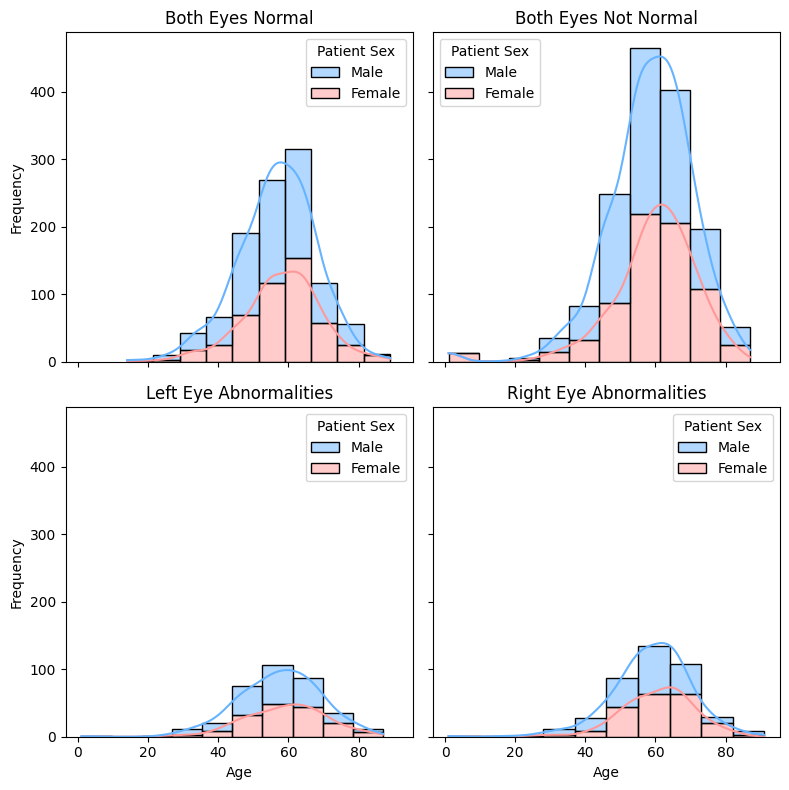

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()

dataframes = [both_eyes_normal, both_eyes_not_normal, left_eye_abnormalities, right_eye_abnormalities]
titles = ['Both Eyes Normal', 'Both Eyes Not Normal', 'Left Eye Abnormalities', 'Right Eye Abnormalities']
colors = ['#66b3ff', '#ff9999']  # blue for Male, pink for Female

# Plot each dataframe
for i, (eyes, title) in enumerate(zip(dataframes, titles)):
    sns.histplot(eyes, x='Patient Age', hue='Patient Sex',
                hue_order=['Male', 'Female'],
                multiple='stack', palette=colors, bins=10,
                ax=axes[i], kde=True)
    axes[i].set_title(title)
    axes[i].set_xlabel('Age')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

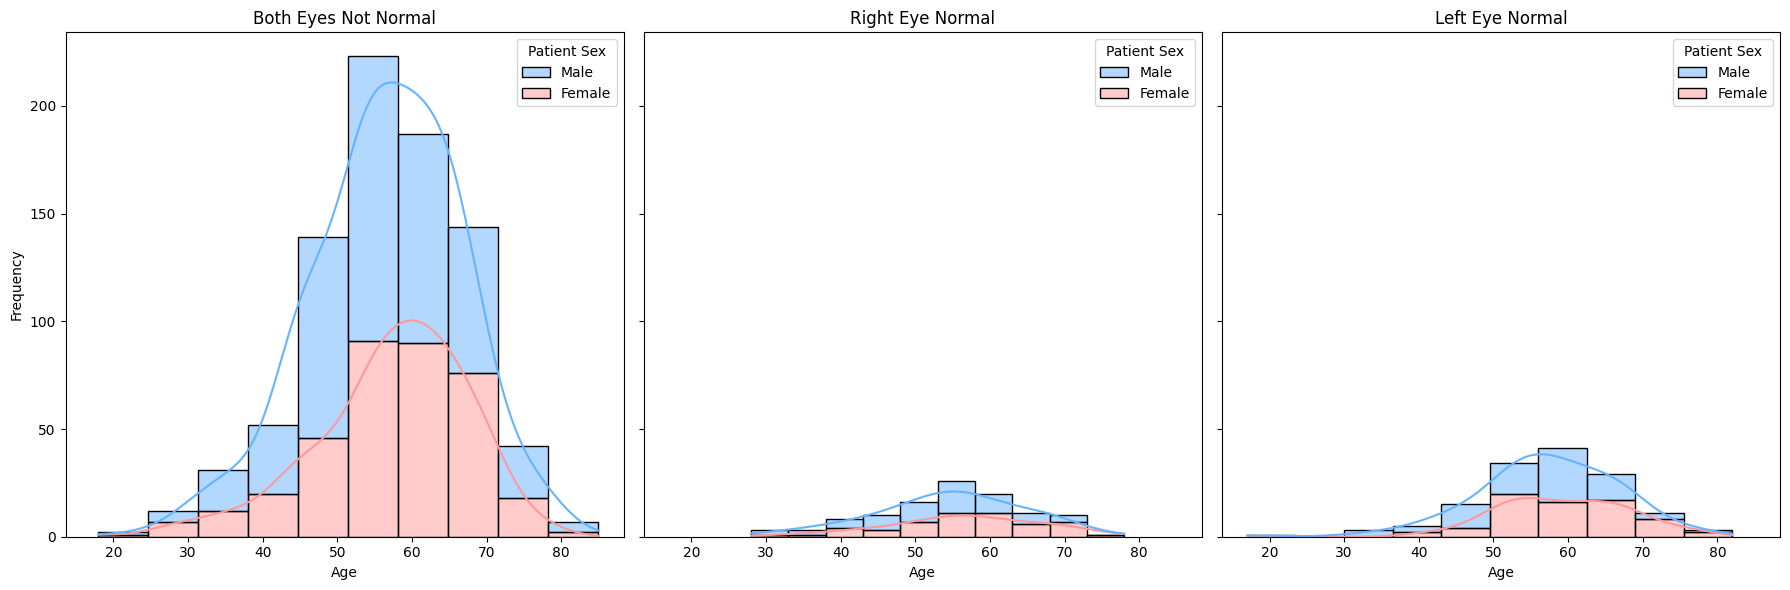

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

dataframes = [both_eyes_not_normal, left_eye_abnormalities, right_eye_abnormalities]

titles = ['Both Eyes Not Normal', 'Right Eye Normal', 'Left Eye Normal']
colors = ['#66b3ff', '#ff9999']

# Plot each dataframe with condition D = 1 applied within the loop
for i, (eyes, title) in enumerate(zip(dataframes, titles)):
    row = i // 3
    col = i % 3
    filtered_df = eyes.query('D == 1')
    if not filtered_df.empty:
        sns.histplot(filtered_df, x='Patient Age', hue='Patient Sex', hue_order=['Male', 'Female'], multiple='stack', palette=colors, bins=10, ax=axes[col], kde=True)
    axes[col].set_title(title)
    axes[col].set_xlabel('Age')
    axes[col].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

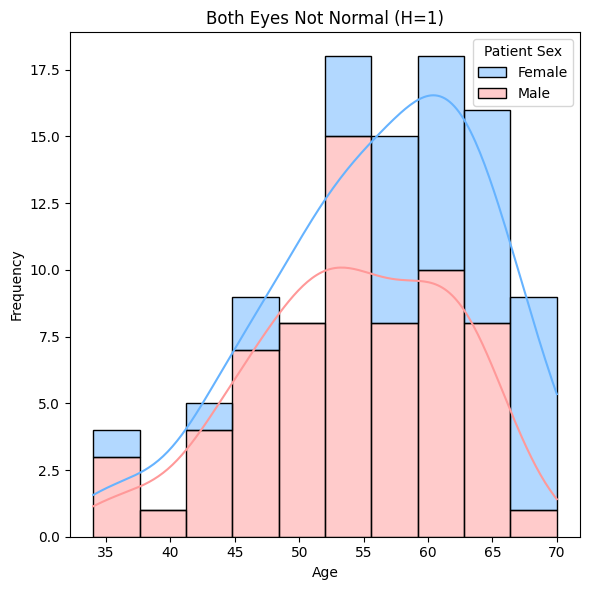

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

# Define the DataFrame and title
eyes = both_eyes_not_normal
title = 'Both Eyes Not Normal (H=1)'
colors = ['#66b3ff', '#ff9999']

# Filter data for H = 1 and plot
filtered_df = eyes.query('H == 1')
if not filtered_df.empty:
    sns.histplot(filtered_df, x='Patient Age', hue='Patient Sex', multiple='stack', palette=colors, bins=10, ax=ax, kde=True)
    ax.set_title(title)
    ax.set_xlabel('Age')
    ax.set_ylabel('Frequency')
else:
    ax.text(0.5, 0.5, 'No data available for H = 1', horizontalalignment='center', verticalalignment='center', fontsize=14, color='red')

# Adjust layout
plt.tight_layout()
plt.show()

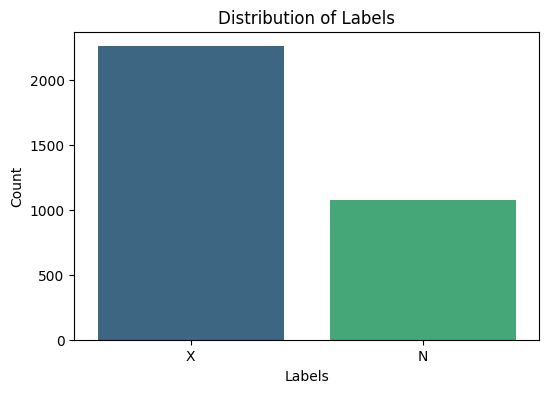

In [ ]:
df.loc[df['labels'] != 'N', 'labels'] = 'X'

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='labels', hue='labels', palette='viridis')

plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')

plt.show()

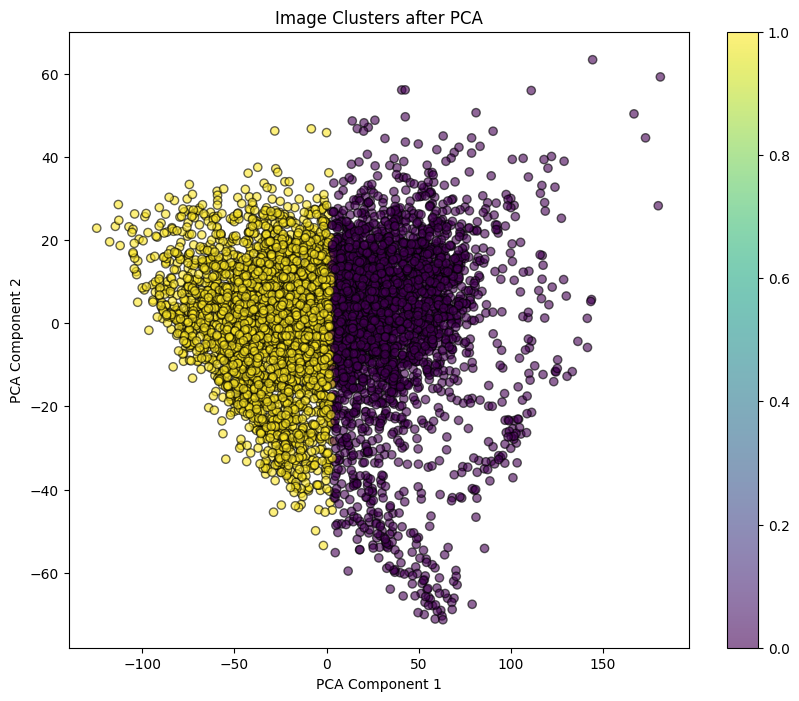

In [ ]:
train_dir = "/content/ODIR5K_full/preprocessed_images"

file_paths = []
features = []

for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith(('jpg', 'png', 'jpeg')):
            file_path = os.path.join(root, file)
            file_paths.append(file_path)

            image = cv2.imread(file_path)
            image = cv2.resize(image, (100, 100))
            avg_color = image.mean(axis=0).mean(axis=0)
            features.append(avg_color)

features = np.array(features)

pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(reduced_features)

eyes = pd.DataFrame({
    'file_path': file_paths,
    'PCA1': reduced_features[:, 0],
    'PCA2': reduced_features[:, 1],
    'cluster': clusters
})


plt.figure(figsize=(10, 8))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis', alpha=0.6, edgecolor='k')
plt.title("Image Clusters after PCA")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

In [ ]:
eyes.head()

,file_path,PCA1,PCA2,cluster
0,/content/ODIR5K_full/preprocessed_images/2952_...,-17.048299,-12.332820,1
1,/content/ODIR5K_full/preprocessed_images/2844_...,-20.658594,-17.557325,1
2,/content/ODIR5K_full/preprocessed_images/2591_...,-2.022096,2.722217,1
3,/content/ODIR5K_full/preprocessed_images/3226_...,31.965907,-0.113598,0
4,/content/ODIR5K_full/preprocessed_images/2832_...,-86.225758,8.241259,1


In [ ]:
eyes['cluster'].value_counts()

,count
cluster,
1,3458
0,2934


In [ ]:
eyes.drop(columns = ['PCA1' , 'PCA2'], axis=1 , inplace = True)

In [ ]:
eyes.head()

,file_path,cluster
0,/content/ODIR5K_full/preprocessed_images/2952_...,1
1,/content/ODIR5K_full/preprocessed_images/2844_...,1
2,/content/ODIR5K_full/preprocessed_images/2591_...,1
3,/content/ODIR5K_full/preprocessed_images/3226_...,0
4,/content/ODIR5K_full/preprocessed_images/2832_...,1


In [ ]:
eyes['cluster'].value_counts()

,count
cluster,
1,3458
0,2934


In [ ]:
eyes['cluster'] = eyes['cluster'].replace({0: 'X', 1: 'N'})

In [ ]:
train_data, test = train_test_split(eyes, test_size=0.4, random_state=42, stratify=eyes['cluster'])
test, valid_data = train_test_split(test, test_size=0.5, random_state=42, stratify=test['cluster'])

print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {valid_data.shape}")
print(f"Testing set shape: {test.shape}")

Training set shape: (3835, 2)
Validation set shape: (1279, 2)
Testing set shape: (1278, 2)


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255 )

# Create an ImageDataGenerator for validation and test data (no data augmentation)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Specify the input size expected by the model
input_size = (224, 224)

# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='file_path',
    y_col='cluster',
    target_size=input_size,
    shuffle = True,
    batch_size=16,
    class_mode='categorical',
    color_mode = 'rgb'
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='file_path',
    y_col='cluster',
     target_size=input_size,
    shuffle = True,
    batch_size=16,
    class_mode='categorical',
    color_mode = 'rgb'
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='file_path',
    y_col='cluster',
    target_size=input_size,
    shuffle=False,
    batch_size=16,
    class_mode='categorical',
    color_mode = 'rgb'
)

Found 3835 validated image filenames belonging to 2 classes.
Found 1279 validated image filenames belonging to 2 classes.
Found 1278 validated image filenames belonging to 2 classes.


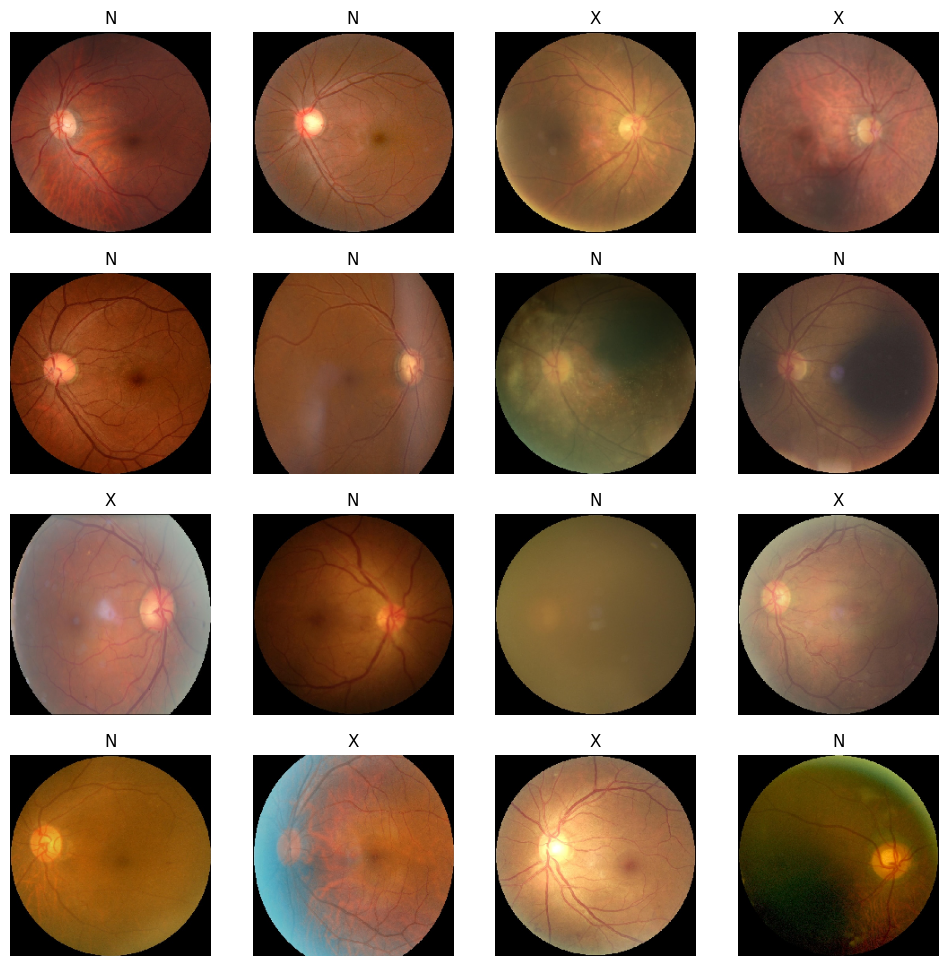

In [ ]:
sample_images, sample_labels = next(train_generator)

# Display the images and labels
plt.figure(figsize=(12, 12))
for i in range(16):
    image = sample_images[i]
    label_index = np.argmax(sample_labels[i])
    label = list(train_generator.class_indices.keys())[label_index]

    plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(label, color='k', fontsize=12)
    plt.axis("off")

plt.show()

cnn

In [ ]:
input_shape = (224, 224, 3)

model = Sequential()
# First block
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape, activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second block
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third block
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer=Adamax(learning_rate=0.002),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,525,218 (24.89 MB)

 Trainable params: 6,525,218 (24.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=valid_generator,validation_steps = None , shuffle = False,)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9399 - loss: 0.2179 - val_accuracy: 0.9515 - val_loss: 0.1773
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.9452 - loss: 0.1958 - val_accuracy: 0.9398 - val_loss: 0.1802
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.9393 - loss: 0.1963 - val_accuracy: 0.9593 - val_loss: 0.1489
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.9572 - loss: 0.1657 - val_accuracy: 0.8655 - val_loss: 0.2859
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.9494 - loss: 0.1719 - val_accuracy: 0.9679 - val_loss: 0.1163
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.9420 - loss: 0.1666 - val_accuracy: 0.9805 - val_loss: 0.1066
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.9605 - loss: 0.1378 - val_accuracy: 0.9750 - val_loss: 0.1114
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 16s 67ms/step - accuracy: 0.9667 - loss: 0.1264 - 

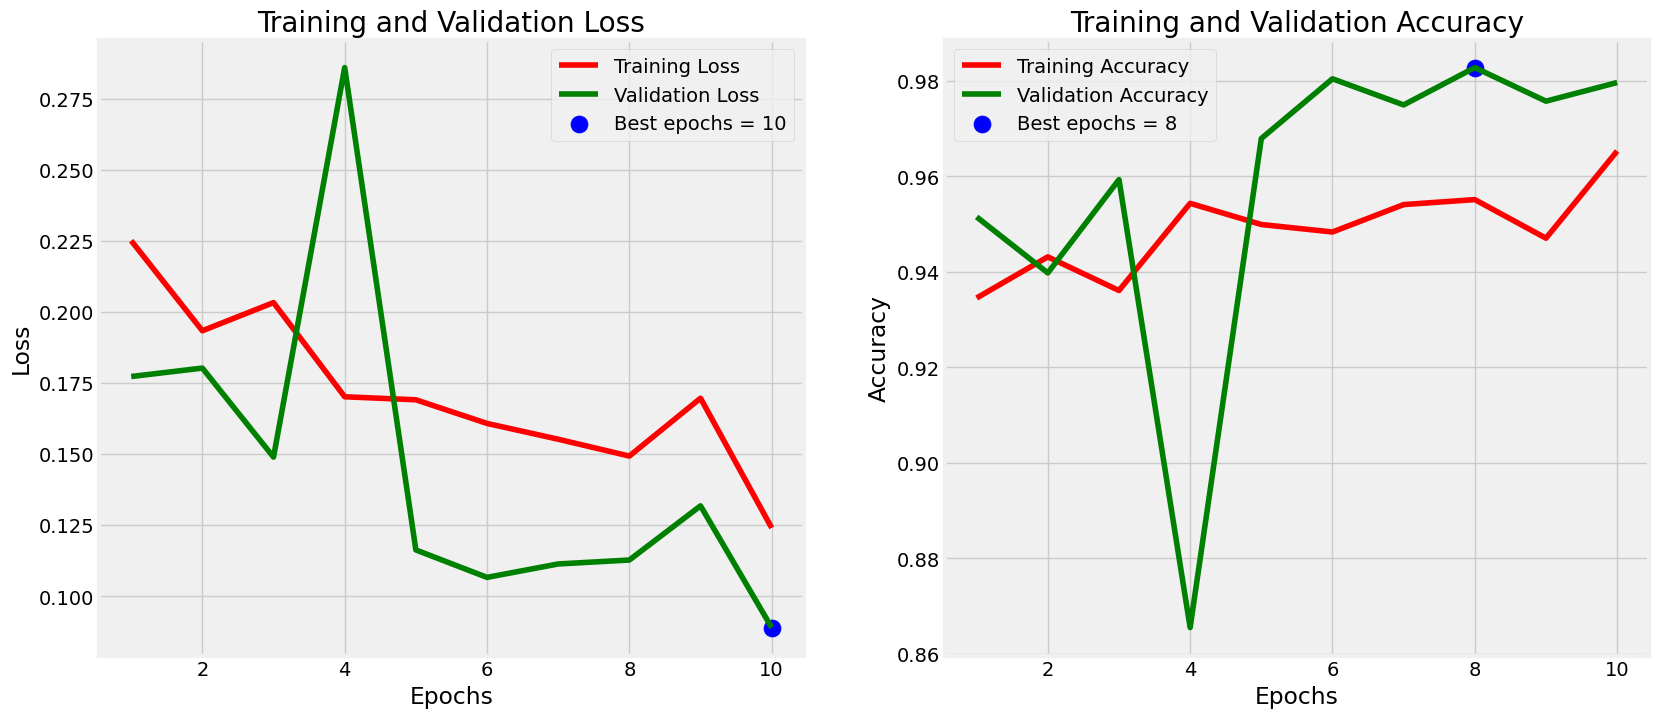

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();


80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step


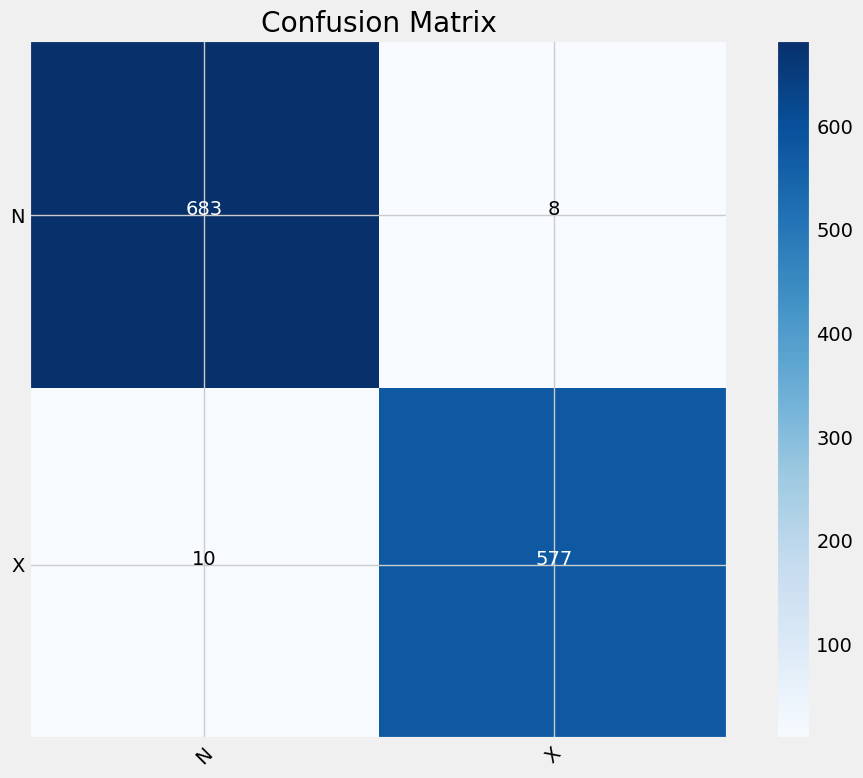

In [ ]:
preds = model.predict(test_generator)

y_pred = np.argmax(preds, axis=1)
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

plt.figure(figsize= (10, 8))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()

plt.show()

In [ ]:
print(classification_report(test_generator.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

           N       0.99      0.99      0.99       691
           X       0.99      0.98      0.98       587

    accuracy                           0.99      1278
   macro avg       0.99      0.99      0.99      1278
weighted avg       0.99      0.99      0.99      1278



# EfficientNetB0

In [ ]:
# ================================
# MODEL: EfficientNetB0
# ================================
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load EfficientNetB0 pretrained on ImageNet
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers (fine-tune later if needed)
for layer in base_model.layers:
    layer.trainable = False

# Custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(2, activation='softmax')(x)

# Build the model
model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ================================
# TRAIN
# ================================
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1
)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,213,797 (16.07 MB)

 Trainable params: 164,226 (641.51 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 77s 202ms/step - accuracy: 0.5055 - loss: 0.7020 - val_accuracy: 0.5410 - val_loss: 0.6894
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.5149 - loss: 0.6975 - val_accuracy: 0.5410 - val_loss: 0.6894
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - accuracy: 0.5143 - loss: 0.6985 - val_accuracy: 0.5410 - val_loss: 0.6917
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.5250 - loss: 0.6918 - val_accuracy: 0.5410 - val_loss: 0.6898
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - accuracy: 0.5369 - loss: 0.6914 - val_accuracy: 0.5410 - val_loss: 0.6895
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 16s 66ms/step - accuracy: 0.5216 - loss: 0.6935 - val_accuracy: 0.5410 - val_loss: 0.6899
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 16s 65ms/step - accuracy: 0.5232 - loss: 0.6920 - val_accuracy: 0.5410 - val_loss: 0.6895
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.5301 - loss: 0.6916 -

# Resnet

In [ ]:
# ================================
# MODEL: ResNet50
# ================================
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load pretrained ResNet50 (no top layer)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Add custom classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ================================
# TRAIN
# ================================
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=20,
    verbose=1
)


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 38s 113ms/step - accuracy: 0.5698 - loss: 0.6903 - val_accuracy: 0.7568 - val_loss: 0.5755
Epoch 2/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.7182 - loss: 0.5760 - val_accuracy: 0.7162 - val_loss: 0.5407
Epoch 3/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 17s 72ms/step - accuracy: 0.7517 - loss: 0.5244 - val_accuracy: 0.7983 - val_loss: 0.5136
Epoch 4/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - accuracy: 0.7867 - loss: 0.4887 - val_accuracy: 0.7772 - val_loss: 0.4716
Epoch 5/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.7864 - loss: 0.4566 - val_accuracy: 0.7834 - val_loss: 0.4611
Epoch 6/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 18s 76ms/step - accuracy: 0.7758 - loss: 0.4711 - val_accuracy: 0.7858 - val_loss: 0.4508
Epoch 7/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.7869 - loss: 0.4521 - val_accuracy: 0.7881 - val_loss: 0.4424
Epoch 8/20
240/240 ━━━━━━━━━━━━━━━━━━━━ 18s 74ms/step - accuracy: 0.7881 - loss: 0.4486 -